In [ ]:
import gurobipy as gp
import os
import shutil


class MILPFindReboundPath:
    """
    MILPFindReboundPath
    使用MILP寻找Rebound友好的截断差分路线
    """

    def __init__(self, ciphername, rounds, begin_round, end_round) -> None:
        self.__model = gp.Model()
        self.__model.setParam(gp.GRB.Param.OutputFlag, False)

        self.__ciphername = ciphername
        self.__rounds = rounds

        self.__num_blocks = 12
        self.__block_size = 16
        # self.__state_size = 16
        self.__state_size = self.__num_blocks * self.__block_size ##192

        self.__key_size = 16
        self.__state_vars = []
        self.__auxi_vars = []
        self.__aes_type = 128
        self.__inbound_begin_round = begin_round
        self.__inbound_end_round = end_round
        # block activation matrix: 默认全部激活（rounds x num_blocks）
        # 可以通过 set_block_activation 方法设置为只部分块激活
        self.__block_active = [[True for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]

        self.__milp_lpfile_folder = ""
        self.__milp_lpfile_name = ""

    def generate_variables(self) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        num_blocks = self.__num_blocks
        block_size = self.__block_size
        num_cols = 4

        # 清理旧变量（防止重复调用时追加）
        self.__state_vars = []
        self.__auxi_vars = []

        for r in range(rounds+1): ###########让多循环一轮
            round_vars = []
            for b in range(num_blocks):
                block_vars = []
                for i in range(block_size):
                    block_vars.append(model.addVar(vtype=gp.GRB.BINARY, name=f"x_{r}_{b}_{i}"))
                round_vars.append(block_vars)
            self.__state_vars.append(round_vars)

        for r in range(rounds): #######辅助变量也多循环一轮
            round_auxi = []
            for b in range(num_blocks):
                block_auxi = []
                for c in range(num_cols):
                    block_auxi.append(model.addVar(vtype=gp.GRB.BINARY, name=f"d_{r}_{b}_{c}"))
                round_auxi.append(block_auxi)
            self.__auxi_vars.append(round_auxi)

        model.update()

    def mds_cocnstraints(self, var_in, var_out, auxi_var) -> None:
        model = self.__model
        model.addConstr(sum(var_in) + sum(var_out) - 5 * auxi_var >= 0)
        model.addConstr(sum(var_in) - auxi_var >= 0)
        model.addConstr(sum(var_out) - auxi_var >= 0)
        for i in range(4):
            model.addConstr(auxi_var - var_in[i] >= 0)
            model.addConstr(auxi_var - var_out[i] >= 0)
        model.update()

    def aes_round(self, index_in:int, index_out: int, r: int) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars
        block_in = self.__state_vars[r][index_in]
        block_out = self.__state_vars[r + 1][index_out]
        
        index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
        # for r in range(rounds - 1):
        for i in range(4):
            var_in = []
            var_out = []
            for j in range(4):
                var_in.append(block_in[index[i][j]])
            for j in range(4):
                var_out.append(block_out[4 * i + j])
            self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])

    def aes_temp(self, block_in, block_out, index_out, r) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars

        index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
        # for r in range(rounds - 1):
        for i in range(4):
            var_in = []
            var_out = []
            for j in range(4):
                var_in.append(block_in[index[i][j]])
            for j in range(4):
                var_out.append(block_out[4 * i + j])
            self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])


    def xor_block_constraints(self, r, index_in1, index_in2, index_out) -> None:
        """
        为两个块的 XOR 构建 MILP 约束
        block_in1, block_in2, block_out: 列表 长度为16 每个元素是Gurobi二进制变量
        """
        # model = self.__model
        # for i in range(16):
        #     x = block_in1[i]
        #     y = block_in2[i]
        #     z = block_out[i]

        #     # XOR 活跃性约束
        #     model.addConstr(z >= x)
        #     model.addConstr(z >= y)
        #     model.addConstr(z <= x + y) ###############一般似乎也不考虑1+1=0的情况，默认1+1是1
        
        # model.update()
        model = self.__model
        state_vars = self.__state_vars

        block_in1 = state_vars[r][index_in1]
        block_in2 = state_vars[r][index_in2]
        block_out = state_vars[r + 1][index_out]

        for i in range(16):
            x = block_in1[i]
            y = block_in2[i]
            z = block_out[i]

            # XOR 活跃性约束
            model.addConstr(z >= x)
            model.addConstr(z >= y)
            model.addConstr(z <= x + y)  # 默认1+1=1
            
        model.update()

    def xor_block_constraints_tmp(self, r, block_in1, block_in2, block_out) -> None:
        """
        为两个块的 XOR 构建 MILP 约束
        block_in1, block_in2, block_out: 列表 长度为16 每个元素是Gurobi二进制变量
        """
        model = self.__model
        for i in range(16):
            x = block_in1[i]
            y = block_in2[i]
            z = block_out[i]

            # XOR 活跃性约束
            model.addConstr(z >= x)
            model.addConstr(z >= y)
            model.addConstr(z <= x + y) ###############一般似乎也不考虑1+1=0的情况，默认1+1是1
        
        model.update()

    def aes_then_xor(self, index_in: int, index_in2: int, index_out: int, r: int) -> None:
        """
        block_in  : 先过 AES 的块
        block_in2 : 与 AES 输出 XOR 的块
        block_out : 输出块
        r         : 当前轮号
        """
        # 1. AES 输出到临时块
        # block_tmp = [self.__model.addVar(vtype=gp.GRB.BINARY, name=f"tmp_r{r}_{i}") for i in range(16)]
        # self.aes_round(block_in, block_tmp, r)  # AES约束

        # # 2. XOR 临时块与 block_in2，得到最终输出
        # self.xor_block_constraints(block_tmp, block_in2, block_out)
        # 1. AES 输出到临时块
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars

        block_tmp = [self.__model.addVar(vtype=gp.GRB.BINARY, name=f"tmp_r{r}_{i}") for i in range(16)]
        block_in = self.__state_vars[r][index_in]
        block_out = self.__state_vars[r + 1][index_out]
        block_in2 = self.__state_vars[r][index_in2]

        self.aes_temp(block_in, block_tmp, index_out, r)
        self.xor_block_constraints_tmp(r, block_tmp, block_in2, block_out)
        

    def Permutation(self, r) -> None:
        model = self.__model
        state_size = self.__state_size
        state_vars = self.__state_vars
        # state_in = state_vars[r]
        # state_out = state_vars[r + 1]

        self.aes_then_xor(2, 8, 0, r)
        self.xor_block_constraints(r, 0, 9, 1)
        self.aes_then_xor(3, 10, 2, r)
        self.aes_then_xor(1, 4, 3, r)
        self.xor_block_constraints(r, 6, 11, 4)
        self.xor_block_constraints(r, 7, 8, 5)
        self.xor_block_constraints(r, 2, 3, 6)
        self.xor_block_constraints(r, 1, 5, 7)
        self.aes_then_xor(6, 4, 8, r)
        self.aes_round(0, 9, r)
        self.aes_then_xor(7, 9, 10, r)
        self.xor_block_constraints(r, 5, 10, 11)

    # def Permutation_Inv() -> None:
        

    # def set_object_function(self) -> None:
    #     equation = []
    #     for i in range(self.__rounds):
    #         equation.append(sum(self.__state_vars[i]))
    #     self.__model.setObjective(sum(equation), gp.GRB.MINIMIZE)
    #     self.__model.update()

    def set_object_function(self) -> None:
        """
        目标函数: 最小化所有块的激活数量
        """
        model = self.__model
        obj_terms = []
        for r in range(self.__rounds):
            for b in range(self.__num_blocks):
                obj_terms.extend(self.__state_vars[r][b])  # 每个块16个比特
        model.setObjective(gp.quicksum(obj_terms), gp.GRB.MINIMIZE)
        model.update()

    # def init_constraints(self) -> None:
    #     self.__model.addConstr(sum(self.__state_vars[0]) >= 1)
    #     self.__model.update()

    def init_constraints(self) -> None:
        """
        初始轮至少有一个比特被激活
        """
        model = self.__model
        first_round_terms = []
        for b in range(self.__num_blocks):
            first_round_terms.extend(self.__state_vars[0][b])
        model.addConstr(gp.quicksum(first_round_terms) >= 1)
        model.update()


    # def inbound_constraints(self) -> None:
    #     equation = []
    #     begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
    #     for r in range(begin_round, end_round + 1):
    #         equation.append(sum(self.__state_vars[r]))
    #     self.__model.addConstr(sum(equation) <= self.__state_size + self.__key_size)
    #     self.__model.update()

    
    def inbound_constraints(self) -> None:
        """
        限制 inbound 阶段总活跃比特数
        """
        model = self.__model
        begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
        inbound_terms = []
        for r in range(begin_round, end_round + 1):
            for b in range(self.__num_blocks):
                inbound_terms.extend(self.__state_vars[r][b])
        model.addConstr(gp.quicksum(inbound_terms) <= self.__state_size + self.__key_size)
        model.update()


    # def outbound_constraints(self) -> None:
    #     begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
    #     forward_equation = [] ############
    #     state_vars = self.__state_vars[: begin_round - 1]
    #     index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
    #     for r in range(begin_round - 1):
    #         temp_equation = []
    #         for i in range(4):
    #             temp_var = []
    #             for j in range(4):
    #                 temp_var.append(state_vars[r][index[i][j]])
    #             temp_equation.append(sum(temp_var))
    #         forward_equation.append(temp_equation)

    #     backward_equation = []
    #     for r in range(end_round + 2, self.__rounds):
    #         temp_equation = []
    #         for i in range(4):
    #             temp_var = []
    #             for j in range(4):
    #                 temp_var.append(self.__state_vars[r][i * 4 + j])
    #             temp_equation.append(sum(temp_var))
    #         backward_equation.append(temp_equation)

        # l = 0
        # for r in range(begin_round - 1):
        #     for i in range(4):
        #         l += self.__auxi_vars[r][i] * (4 - forward_equation[r][i])

        # back_auxi_vars = self.__auxi_vars[end_round + 1 : self.__rounds - 1]
        # for r in range(len(backward_equation)):
        #     for i in range(4):
        #         l += back_auxi_vars[r][i] * (4 - backward_equation[r][i])

        # self.__model.setObjective(8 * (l + sum(self.__state_vars[0])), gp.GRB.MINIMIZE)
        # self.__model.addConstr(
        #     8 * (l + sum(self.__state_vars[0])) <= int(self.__aes_type / 2)
        # )

        # begin_state = self.__state_vars[0]
        # end_state = self.__state_vars[self.__rounds - 1]
        # index_sr = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]
        # after_sr_state = []
        # for i in range(16):
        #     after_sr_state.append(end_state[index_sr[i]])
        # for i in range(16):
        #     self.__model.addConstr(begin_state[i] == after_sr_state[i])

        # self.__model.update()


    def outbound_constraints(self) -> None:
        """
        限制 outbound 阶段辅助变量和块活跃性
        """
        model = self.__model
        begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round

        # 前向阶段 (0 到 begin_round-2)
        forward_auxi_sum = 0
        for r in range(begin_round - 1):
            for b in range(12):#############这里从4改成了12，下面也是
                # 每列4比特
                col_sum = gp.quicksum(self.__state_vars[r][b][i] for i in range(4))
                forward_auxi_sum += self.__auxi_vars[r][b][0] * (4 - col_sum)  # MDS约束对应的辅助变量

        # 后向阶段 (end_round+2 到 rounds-2)
        back_auxi_sum = 0
        back_auxi_vars = self.__auxi_vars[end_round + 1 : self.__rounds - 1]
        for r, auxi_block in enumerate(back_auxi_vars):
            for b in range(12):
                col_sum = gp.quicksum(self.__state_vars[end_round + 2 + r][b][i] for i in range(4))
                back_auxi_sum += auxi_block[b][0] * (4 - col_sum)

        # 设置目标函数和约束
        first_round_sum = gp.quicksum(self.__state_vars[0][b][i] for b in range(self.__num_blocks) for i in range(16))
        model.setObjective(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum), gp.GRB.MINIMIZE)
        model.addConstr(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum) <= int(self.__aes_type / 2))

        # ShiftRow约束: 输入轮 == 输出轮
        begin_state = self.__state_vars[0]
        end_state = self.__state_vars[self.__rounds - 1]
        index_sr = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]
        for b in range(self.__num_blocks):
            for i in range(16):
                model.addConstr(begin_state[b][i] == end_state[b][index_sr[i]])

        model.update()

    # def construct_active_sbox_model(self) -> None:
    #     self.generate_variables()
    #     self.aes_round()
    #     self.set_object_function()
    #     self.init_constraints()

    #     folder_path = "AES_active_sbox_milp_lp"
    #     filename = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
    #     if not os.path.exists(folder_path):
    #         os.makedirs(folder_path)
    #     self.__model.write(f"{folder_path}/{filename}")

    def construct_active_sbox_model(self, r) -> None:
        """
        构造一个普通的 active-sbox MILP 对所有轮、对所有块执行 AES 块 -> 同块）
        这样可以得到最小活跃 S-box 的基线模型。
        """
         # ========== 1) 重置模型（避免重复变量/约束） ==========
        self.__model = gp.Model()
        self.__model.setParam(gp.GRB.Param.OutputFlag, False)
        # 生成变量
        self.generate_variables()

        # 对每个 r 从 0 到 rounds-2， 对每个块 b 做 aes_round(b -> b)
        for r in range(self.__rounds - 1):
            self.Permutation(r)

        # 目标 + 基本约束
        self.set_object_function()
        self.init_constraints() ###########这部分代码没有写入文件

    # def construct_rebound_friend_model(self) -> None:
    #     self.generate_variables()
    #     self.aes_round()
    #     self.inbound_constraints()
    #     self.outbound_constraints()
    #     self.init_constraints()

    #     self.__milp_lpfile_folder = f"{self.__ciphername}_rebound_milp_lp"
    #     self.__milp_lpfile_name = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
    #     if not os.path.exists(self.__milp_lpfile_folder):
    #         os.makedirs(self.__milp_lpfile_folder)
    #     self.__model.write(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    def construct_rebound_friend_model(self, r) -> None:
        """
        构造 Rebound-friendly 的完整模型：
        - 先生成变量
        - 然后每轮执行 Permutation(r)（你定义的块级 AES/XOR 调用序列）
        - 再加入 inbound/outbound/init 等约束
        - 写入 lp
        """
        # 生成变量（清理旧的）
        self.generate_variables()

        # 对每一轮 r 构建该轮的置换约束（Permutation 是你之前定义好的块级组合）########原函数也是只走了一轮
        for r in range(self.__rounds - 1):
            self.Permutation(r)

        # 加入 inbound/outbound/init 等约束（基于新的 block 结构）
        self.inbound_constraints()
        self.outbound_constraints()
        self.init_constraints()

        # 保存 lp 文件
        self.__milp_lpfile_folder = f"{self.__ciphername}_rebound_milp_lp"
        self.__milp_lpfile_name = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
        if not os.path.exists(self.__milp_lpfile_folder):
            os.makedirs(self.__milp_lpfile_folder)
        self.__model.write(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    # def remove_foler(self):
    #     shutil.rmtree(self.folder_path)

    def remove_folder(self):
        """删除上次写入的模型文件夹（安全检查存在性）"""
        if hasattr(self, "_MILPFindReboundPath__milp_lpfile_folder"):
            folder = self.__milp_lpfile_folder
        else:
            folder = self.__milp_lpfile_folder
        if folder and os.path.exists(folder):
            shutil.rmtree(folder)

    # def solver(self):
    #     self.construct_rebound_friend_model()
    #     model = self.__model
    #     model.optimize()
    #     os.remove(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    #     if model.status == gp.GRB.OPTIMAL:
    #         obj = model.getObjective()
    #         obj_value = obj.getValue()
    #         print("截断差分概率:", obj_value)
    #         solution = [[0 for i in range(16)] for i in range(self.__rounds)]
    #         mds_solution = [[0 for i in range(4)] for i in range(self.__rounds)]
    #         state_vars = self.__state_vars
    #         auxi_vars = self.__auxi_vars
    #         for i in range(len(state_vars)):
    #             for j in range(16):
    #                 if state_vars[i][j].xn == 1:
    #                     solution[i][j] = 1
    #         for i in range(len(auxi_vars)):
    #             for j in range(4):
    #                 if auxi_vars[i][j].xn == 1:
    #                     mds_solution[i][j] = 1

    #         return solution, mds_solution, obj_value
    #     else:
    # #         return None


    # def solvers(self):
    #     # self.construct_active_sbox_model()
    #     self.construct_rebound_friend_model()
    #     model = self.__model
    #     model.setParam("PoolSearchMode", 2)
    #     model.optimize()
    #     obj = model.getObjective()
    #     # print(obj)
    #     # print(obj.getValue())
    #     number_sol = model.getAttr("SolCount")
    #     print("num sols:", number_sol)

    #     result_solution = []

    #     for i in range(number_sol):
    #         model.setParam("SolutionNumber", i)

    #         solution = [[0 for i in range(16)] for i in range(self.__rounds)]
    #         state_vars = self.__state_vars
    #         auxi_vars = self.__auxi_vars
    #         # if model.status == 2:
    #         for i in range(len(state_vars)):
    #             for j in range(16):
    #                 if state_vars[i][j].xn == 1:
    #                     solution[i][j] = 1
    #         result_solution.append(solution)
    #         #             print(state_vars[i][j].xn,state_vars[i][j].VarName)
    #         # for i in range(len(auxi_vars)):
    #         #     for j in range(4):
    #         #         if auxi_vars[i][j].xn==1:
    #         #             print(auxi_vars[i][j].xn,auxi_vars[i][j].VarName)
    #         # for v in model.getVars():
    #         #     if v.xn == 1:
    #         #         print(v.xn, v.VarName)

    #     return result_solution

    def solver(self, r):
        """
        单解求解函数（对应原文 solver
        - 构建 Rebound-friendly 模型
        - 求解最优解
        - 返回 solution, mds_solution, obj_value
        """
        self.construct_rebound_friend_model(r)
        model = self.__model
        model.optimize()

        # 删除 LP 文件（可选）
        if os.path.exists(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}"):
            os.remove(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

        if model.status == gp.GRB.OPTIMAL:
            obj_value = model.getObjective().getValue()

            # 初始化解
            solution = [[[0 for _ in range(16)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]
            mds_solution = [[[0 for _ in range(4)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]

            for r in range(self.__rounds):
                for b in range(self.__num_blocks):
                    for j in range(16):
                        if self.__state_vars[r][b][j].xn == 1:
                            solution[r][b][j] = 1

            for r in range(len(self.__auxi_vars)):
                for b in range(self.__num_blocks):
                    for j in range(4):
                        if self.__auxi_vars[r][b][j].xn == 1:
                            mds_solution[r][b][j] = 1

            return solution, mds_solution, obj_value
        else:
            return None


    def solvers(self, r):
        """
        多解求解函数（对应原文 solvers
        - 构建 Rebound-friendly 模型
        - 开启解池模式获取多个可行解
        - 返回所有解的 state_vars 激活情况
        """
        self.construct_rebound_friend_model(r)
        model = self.__model
        model.setParam("PoolSearchMode", 2)
        model.optimize()

        num_solutions = model.getAttr("SolCount")
        print("Number of solutions:", num_solutions)

        result_solution = []

        for sol_idx in range(num_solutions):
            model.setParam("SolutionNumber", sol_idx)

            solution = [[[0 for _ in range(16)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]
            for r in range(self.__rounds):
                for b in range(self.__num_blocks):
                    for j in range(16):
                        if self.__state_vars[r][b][j].xn == 1:
                            solution[r][b][j] = 1
            result_solution.append(solution)

        return result_solution







输出一个解:
截断差分: [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

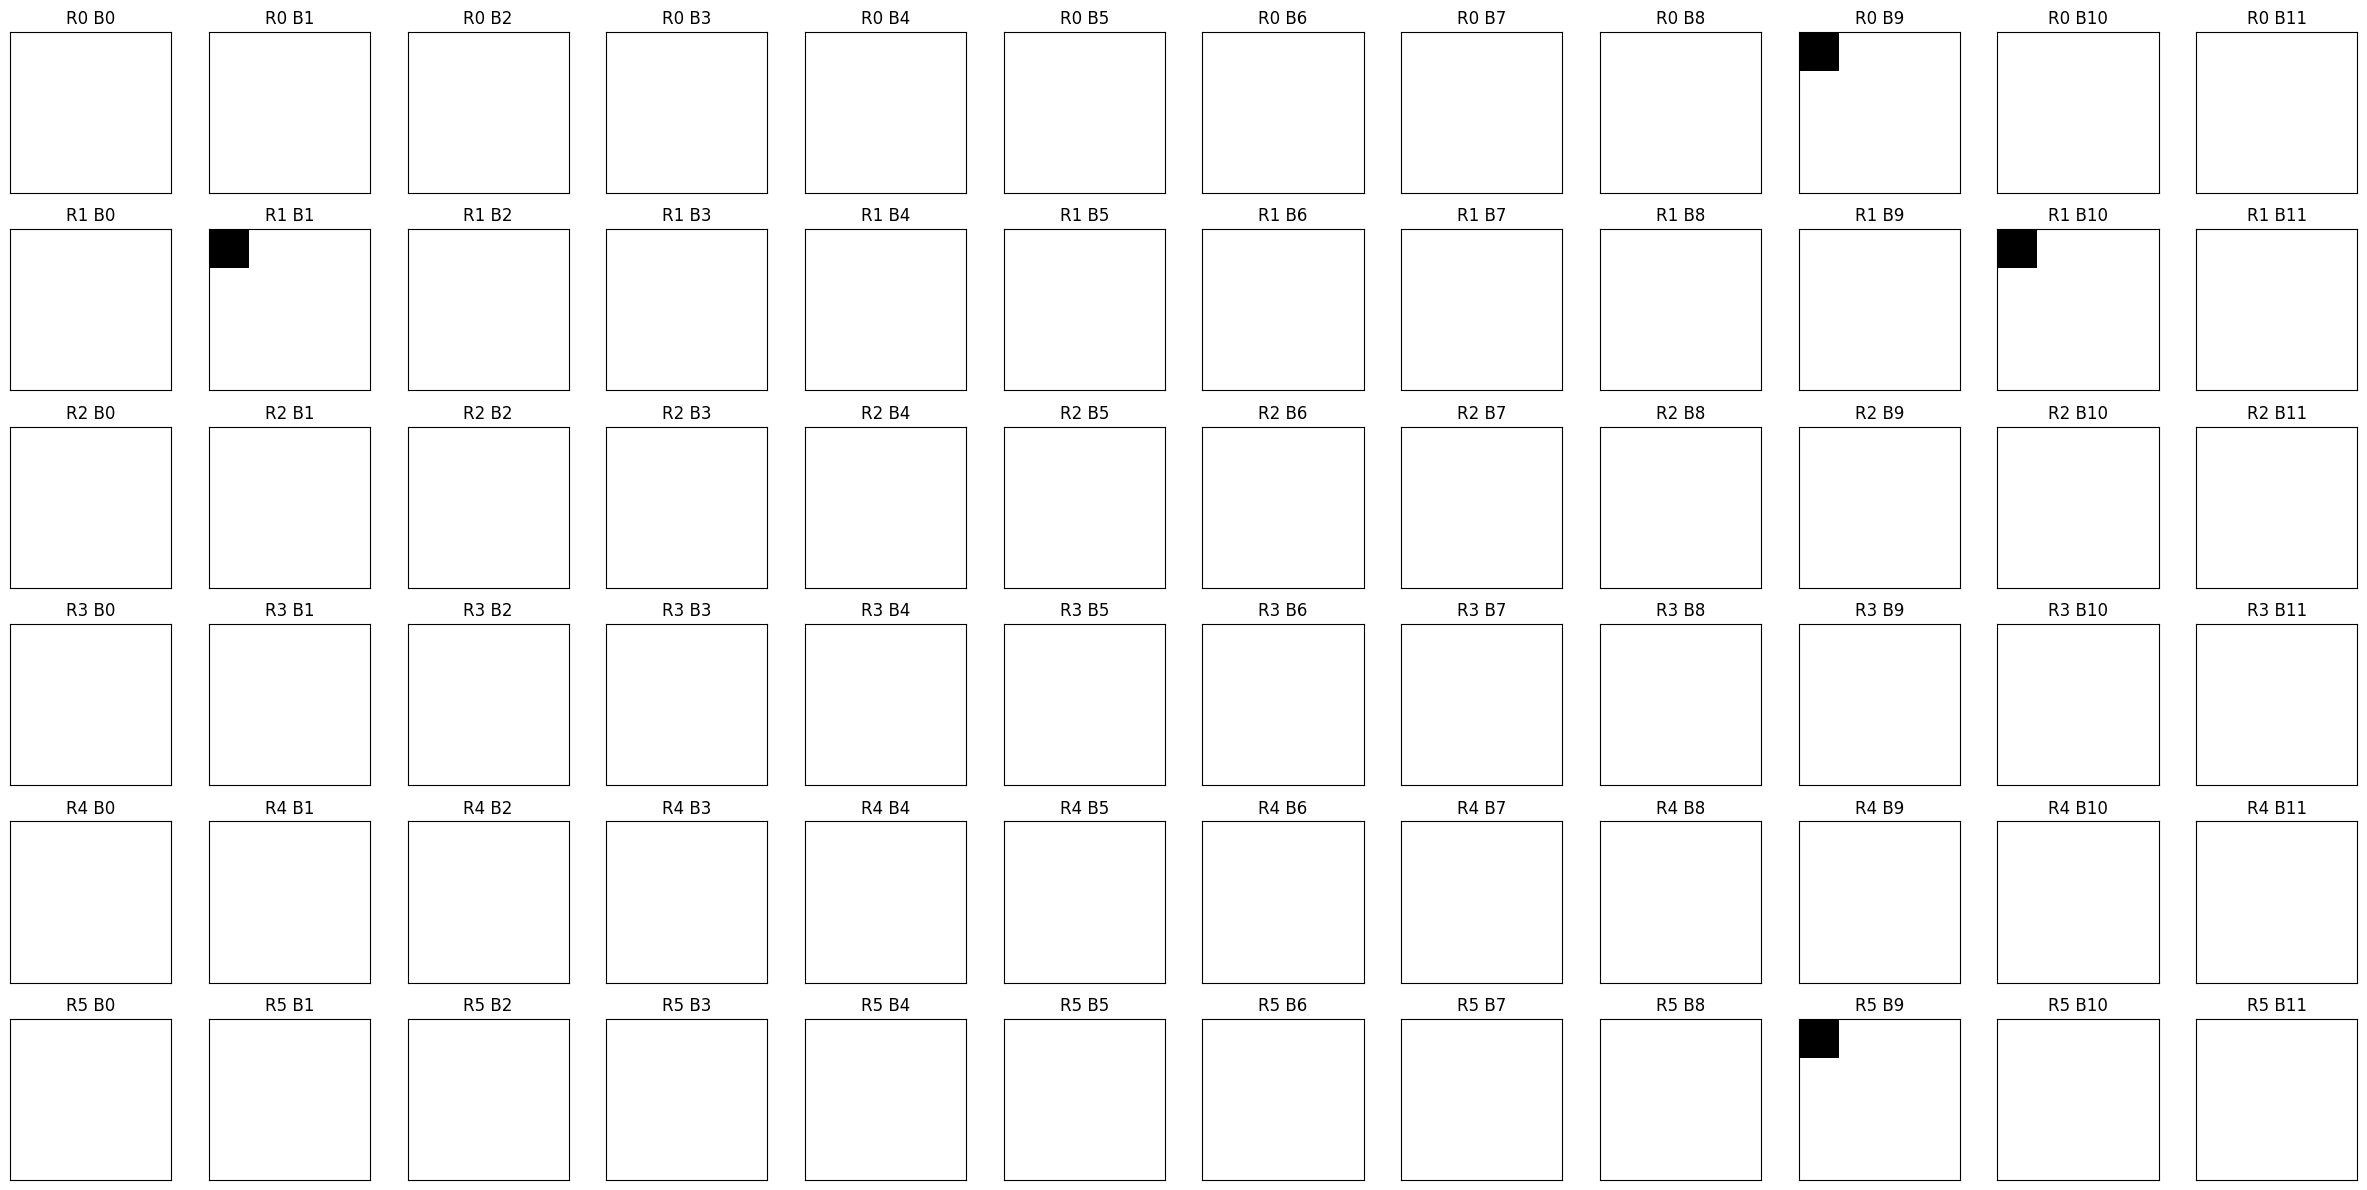

In [ ]:
rounds = 1
inbound_begin_round = 2
inbound_end_round = 4
ciphername = "AES_128"
AES_TD = MILPFindReboundPath(ciphername, rounds, inbound_begin_round, inbound_end_round)

print("输出一个解:")
result = AES_TD.solver(0)
if result is not None:
    solution, mds_solution = result[0], result[1]
    print("截断差分:", solution)
    print("经过MDS矩阵活跃列:", mds_solution)
    inbound_path = solution[inbound_begin_round : inbound_end_round + 1]
    inbound_active_mds = mds_solution[inbound_begin_round:inbound_end_round]
    print("Inbound 阶段路线:", inbound_path)
    print("Inbound 阶段活跃列:", inbound_active_mds)
    print("\n")
else:
    print("请选择其他的轮数进行输入")


import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(6, 12, figsize=(24, 12))  # 6轮 × 12块
for r in range(6):
    for b in range(12):
        block = solution[r][b]
        grid = np.array(block).reshape(4, 4).T
        axes[r, b].imshow(grid, cmap="gray_r")
        axes[r, b].set_title(f"R{r} B{b}")
        axes[r, b].set_xticks([])
        axes[r, b].set_yticks([])

plt.tight_layout()
plt.show()


In [38]:
solution

[[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]]